## Karan Vombatkere
### PHY 256 Project, May 2016
### Monte Carlo Simulations of Stock Prices with Geometric Brownian Motion

### Introduction
Financial assets/securities have been modelled using several techniques. The primary objective of this project is to model stock prices using a Geometric Brownian Motion model and Monte Carlo simulations. The model is based on a stochastic (as opposed to deterministic) variable subject to multiplicative noise. The stochastic differential equation that describes the evolution of stock prices is explained in detail in subsequent sections.

The project was completed in two parts:
1. The first part involved writing code for Geometric Brownian motion and checking and verifying that it worked in a satisfactory manner. This was done using several functions in Python, and using an iterative setup to model subsequent stock prices as a Markov chain, given an initial starting price, $S_0$. The verification process consisted of running multiple simulations or sample random walks and then checking the resulting distributions to see if the stock prices, returns and volatility satisfied certain properties and assumptions.
2. The second stage involved an exploration, where the model was actually applied to real stock prices, and backtested with real stock data for Nike stock. The simulation was done by taking sample values for the return rate, $\mu$ and the volatility, $\sigma$ and observing the level of correlation between the simulated and real data for the stock price evolution.

The simulations took about 10-15 minutes to run completely. Note that all interpretations of simulation results were done by intepreting the parameters such as mean and variance of the resulting distributions of price levels and return rates.

### Notation and Assumptions
This section explains the notation used for the stock prices and any assumptions that are part of the model. The following list of variables and symbols are used in this project:
1. $S_0$ - Initial Stock Price
2. $S_t$ - Stock Price at time, t
3. $\mu$ - Return (drift) rate of stock averaged over a particular period of time
4. $\sigma$ - Volatility (standard deviation) rate of stock averaged over a particular period of time
5. $dt$ - Timestep of simulation, corresponds to the frequency of stock price sampling in a day
6. $N$ - Total number of days simulated.
7. $r$ - Risk free rate, available to anyone for borrowing/lending

The following assumptions regarding the stock market/prices were also made. While these assumptions do help simplify the model considerably, they are quite realistic and help formulate a model in an ideal scenario.
1. The stock prices follow a Markov process, i.e are memoryless and subsequent stock prices only depend on the current value and not on any previous ones.
2. The timestep, $dt$ considered is short compared to N, i.e $\frac{N}{dt} >> 1$
3. The market is complete and efficient and there are no arbitrage opportunities.
4. There are no dividends, transaction costs or tax considerations.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pprint import *
from yahoo_finance import *

### Wiener Process and Geometric Brownian Motion
The Wiener process (also referred to as Brownian motion) is a Markov process with continuous variable and continuous time. For the stochastic variable $z$ it has two important properties:
1. All $\Delta z$ are statistically independent.
2. $dz = \epsilon\sqrt{dt}$

where $\epsilon$ is drawn from a normal distribution 
$$p(\epsilon)=\frac{1}{\sqrt{2\pi}}e^{\frac{-\epsilon^2}{2}}$$

The Wiener Process may be generalized further to the Ito process by adding a drift term $a(x,t) dt$ onto the stochastic process $dz$. 

$$\frac{dS}{S} = \mu dt + \sigma dz = \mu dt + \sigma \epsilon \sqrt{dt}$$

For a stock price, S the above equation which is an Ito process, also known as Geometric Brownian Motion describes the stochastic variability over time. Note that $\mu$ and $\sigma$ are the instantaneous drift (return) and the standard deviation rates respectively. S follows a stochastic process subject to multiplicative noise. It is also important to note here that the Geometric Brownian Motion model avoids the problem of negative stock prices.

### Modelling the Solution to Stock Prices
The stochastic differential equation (SDE) described above has an analytic solution of the following form:
$$S_{t} = S_{0}\exp{((\mu - \frac{\sigma^2}{2})t + \sigma W_{t})}$$

Note that in the above equation, the constants $\mu$ and $\sigma$ correspond to the percentage drift (return) and percentage volatility (standard deviation) rates of the stock prices resepctively. $W_t$ refers to a Wiener process given by $dz = \epsilon \sqrt{dt}$ as described above. This solution equation was used to iteratively calculate $S_t$ for each timestep in the following manner:
$$S_t = S_{t-1}\exp{((\mu - \frac{\sigma^2}{2})t + \sigma \epsilon \sqrt{t})}$$

Here, $t$ is the timestep for the calculation, and each $S_t$ only depends on the previous start price, $S_{t-1}$ as is required by the Brownian motion model since it is a Markov process. Note that by choosing a small timestep, $dt$ we can approach the limit of continuous time.

Thus, given a certain timestep, every subsequent stock price, $S_t$ is completely described by three parameters:
1. The initial 'start' price, $S_{t-1}$
2. The percentage return (drift) rate, $\mu$
3. The volatility or standard deviation rate, $\sigma$

The code below implements the iterative process described above. The timestep is given by $dt$ and corresponds to the frequency with which the stock price is sampled, and $N$ is the total number of days the simulation is run over.

In [2]:
#Geometric Brownian Motion Model
#This follows the Stochastic Process dS/S = (mu)dt + (sigma)dz, dz = eps*sqrt(dt)
#Solution form, S(t) = S(t-1)*exp((mu-sigma^2/2)dt + eps*sqrt(dt)*sigma)

#Use mu = rate of return
#sigma = volatility
#dt = timestep
#Si = Initial (start) price value for each timestep
def geometric_brownian(mu, sigma, dt, Si):
    epsilon = stats.norm.rvs() #Get Normal RV with mean = 0, var=1
    Wt = epsilon*np.sqrt(dt)
    
    #calculate St
    S_t = Si*np.exp((mu-(sigma**2/2))*dt + (Wt*sigma))
    
    return S_t


#Time evolution of prices and returns
#Use the brownian motion model to generate list of prices over N days (timeperiod)
def gen_prices(mu, sigma, dt, Si, N):
    price_arr = np.zeros(N) #Initialize a vector of length N to store price values
    price_arr[0] = Si #Store first price value
    
    return_arr = np.zeros(N) #Initialize vector to store return values
    return_arr_log = np.zeros(N) #Vector to store log return values
    
    #Use for loop and call geometric_brownian function to generate subsiquent values
    #Also calculate price returns between consecutive N
    for i in range (1,N):
        #Note that price[i-1] is the Si for each iteration
        price_arr[i] = geometric_brownian(mu, sigma, dt, price_arr[i-1])
        
        #R = (S(t) - S(t-1))/S(t-1)
        return_arr[i] = (price_arr[i] - price_arr[i-1])/price_arr[i-1]
        #R = log(S(t)/S(t-1))
        return_arr_log[i] = np.log((price_arr[i])/price_arr[i-1])

    
    return price_arr, return_arr, return_arr_log


### Running a Single Simulation/Walk
This part of the code simply calls the functions written above and plots results. Sample values for the return and volatility rates, the start price and the timestep were given. The figures in the order of appearance below show:
1. The evolution of the stock price, $S_t$ as a function of $N$
2. The distribution of the stock price levels, plotted as a histogram.
3. The distribution of returns and log returns, also plotted as a histogram.

Note that the plots below cannot be directly interpreted to mean/signify anything, since this just corresponds to 1 random walk. However, the plots do allow one to develop some intuition and understanding regarding the input paramters and general price evolution. They also allow one to check roughly if the code works correctly, since it is easy to observe that the price indeed does not take a negative value and evolves in a somewhat similar manner as actual stock prices. Multiple simulations were run in subsequent sections to actually verify correctness of the model.

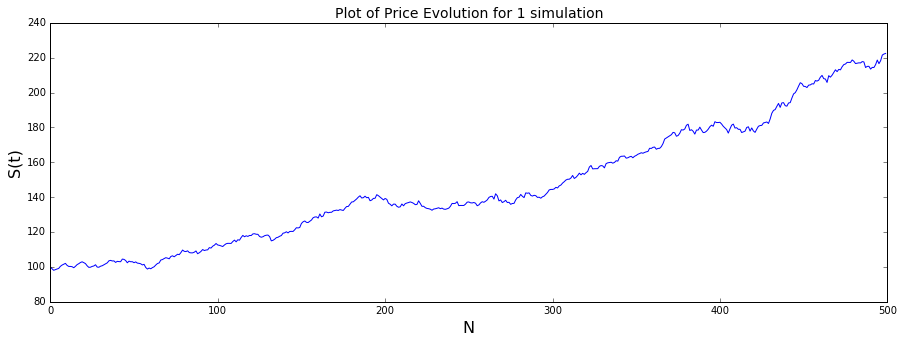

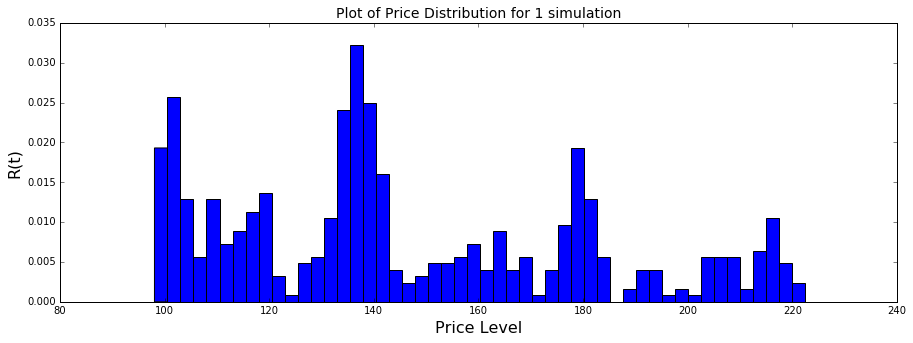

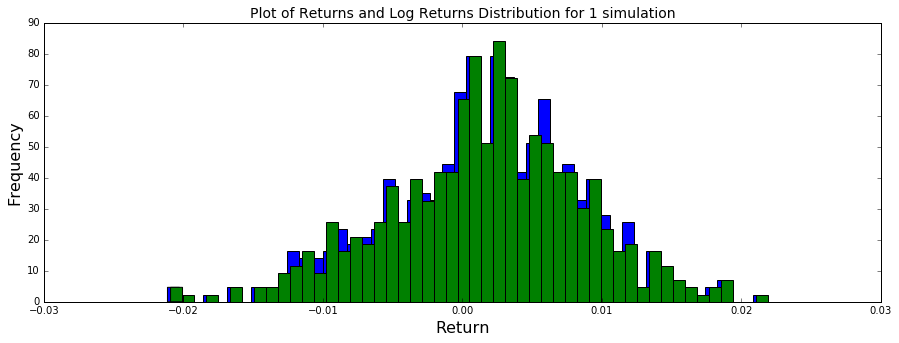

In [16]:
#Run a single simulation to check functionality 
#Test with sample values for mu, sigma and Si
mu = 0.15
sigma = 0.07
Si = 100
N = 500
dt = 0.01

#Call Function
Slist, Rlist, Rloglist = gen_prices(mu, sigma, dt, Si, N)
Nval = np.linspace(0,N-1,N)

#Plot results
plt.figure(figsize=(15,5))
plt.title("Plot of Price Evolution for 1 simulation", fontsize=14)
plt.xlabel("N",fontsize=16)
plt.ylabel("S(t)",fontsize=16)
plt.plot(Nval,Slist)

plt.figure(figsize=(15,5))
plt.title("Plot of Price Distribution for 1 simulation", fontsize=14)
plt.xlabel("Price Level",fontsize=16)
plt.ylabel("R(t)",fontsize=16)
n, bins, patches=plt.hist(Slist,bins=50,normed=1,label="S")

#Plot returns
plt.figure(figsize=(15,5))
plt.title("Plot of Returns and Log Returns Distribution for 1 simulation", fontsize=14)
plt.xlabel("Return",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
n, bins, patches=plt.hist(Rloglist,bins=50,normed=1,label="Log(R)")
n, bins, patches=plt.hist(Rlist,bins=50,normed=1,label="R")


In [4]:
#Functions to calculate return and std dev of price array
#Use to get mu_multiple and sigma_multiple
#takes price array as input and returns mu and sigma
def avg_returns(price_array):
    mu_temp = np.zeros(len(price_array)) #Temporary array to store values
    mu_single = 0
    sigma_single = 0
    
    #Calculate the return for each iteration and store in array mu_temp
    for i in range(1,len(price_array)):
        mu_temp[i-1] = np.log(price_array[i]/price_array[i-1])
    
    #Calculate the mean return rate, mu and mean volatility, sigma of the simulation
    mu_single = np.mean(mu_temp)
    sigma_single = np.std(mu_temp)
    
    return mu_single, sigma_single


#Monte Carlo Simulations for the Geometric Brownian Motion Evolution
#Run several simulations to generate several possible price evolution arrays
#Use this to calculate the averaged volatility and return rate exhibited
def gen_multiple(mu, sigma, dt, Si, N, sim_count):
    calc_prices = np.zeros(shape=(N,sim_count)) #Create an array to store simulation values
    #For the calc_prices array we only care about the values
    #Create arrays to store values of mu and sigma for each
    mu_multiple = np.zeros(sim_count)
    sigma_multiple = np.zeros(sim_count)
    
    Nval = np.linspace(0,N-1,N)
    #Run the simulations and also plot the results of each price evolution
    plt.figure(figsize=(20,20))
    plt.title("Plot of Price Evolution, S(t) for %d Simulations" %sim_count, fontsize=16)
    plt.xlabel("N",fontsize=16)
    plt.ylabel("S(t)",fontsize=16)
    for i in range(sim_count):
        calc_prices[:,i],a,b = gen_prices(mu, sigma, dt, Si, N)
        plt.plot(Nval, calc_prices[:,i])
        
        mu_multiple[i],sigma_multiple[i] = avg_returns(calc_prices[:,i])
        
    return calc_prices, mu_multiple, sigma_multiple


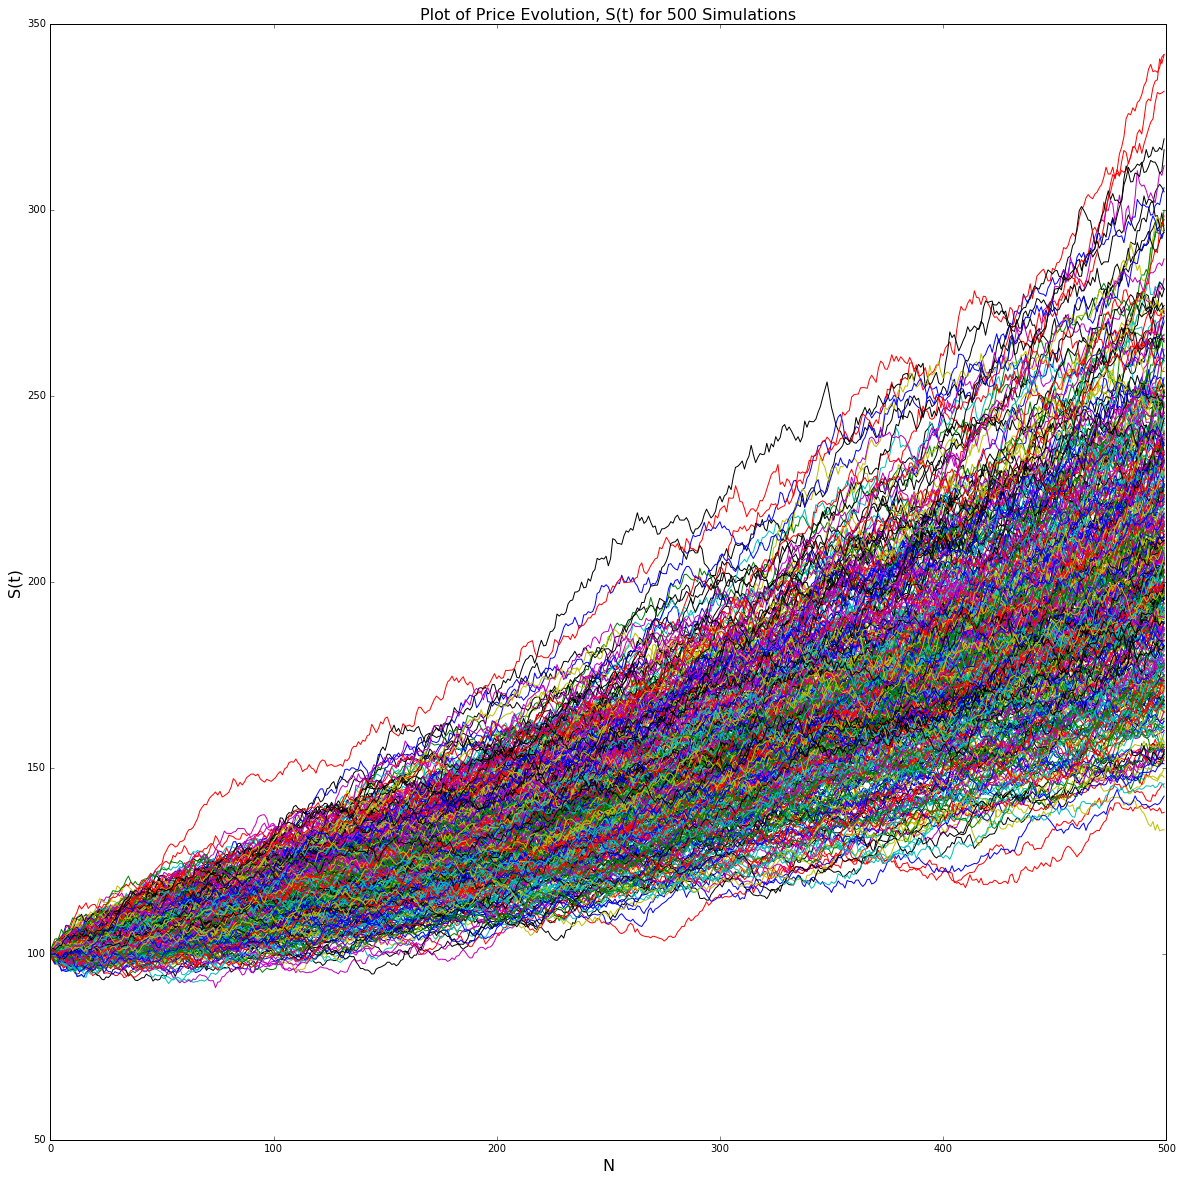

In [8]:
#Run multiple simulations with sample values for the input parameters
mu = 0.15
sigma = 0.07
Si = 100
N = 500
dt = 0.01
sim_count = 500

#Call the function and run the simulations
prices_multiple, mu_arr, sigma_arr = gen_multiple(mu, sigma, dt, Si, N, sim_count)


### Checking and Testing the Code for Multiple Simulations
The above code contains a function to run several simulations for a random walk described by Geometric Brownian Motion. Another function to calculate the average return and volatility levels for a given input array was also written. Both these functions were used to generate several simulations/random walks, which are plotted in the figure above. 

The figure above shows the plots of 500 simulations run for the same start price, $S_0 = 100$ and return and volatility rates, $\mu = 0.2$ and $\sigma = 0.07$. The timestep used was $dt=0.01$ indicating frequent sampling of stock prices each day. Each of the lines represent a sample random walk modelled using the Geometric Brownian Motion model described previously. The data generated using these simulations is then analyzed by plotting the distributions of the stock prices, returns and standard deviations. These distributions of price levels, returns and volatility rates was then analyzed to check for correctness and consistency.

It can be seen from the first plot below that the price levels follow an approximate lognormal distribution. This is in fact an expected result. The solution, $S_t$ is a log-normally distributed random variable with expected value and variance given by:
$$E[S_t] = S_0 e^{(\mu N t)}$$
$$Var[S_t] = S_0^2 e^{(2 \mu N t)} (e^{\sigma^2 N t} - 1)$$

It can be seen below from the first plot, that for sim_count = 500 simulations, the price levels are indeed approximately log-normally distributed with a mean of about 200. The mean and variance measured using the stats.lognorm.fit function also matched the above defined values within a reasonable margin of error. For the simulation run with the parameters given above, they were computed to be:
$$E[S_t] = 211.7$$
$$Var[S_t] = 33.34$$

The second plot below shows the distribution of return rates for the simulations run above. It can be observed easily that the returns are normally distributed with a mean of about 0.15, which was the input value for $\mu$ for the simulations. This normal distribution of return rates is also an expected result with the Brownian Motion model. The third plot below shows the distribution of standard deviation rates, which can also be observed to be normally distributed with a mean of about 0.07, which was the input value of $\sigma$ for the simulations.

Thus, the above discussion verifies that the Geometric Brownian Motion model coded indeed works as expected and generates results corresponding to the properties and assumptions of the model. Self-similarity was also shown to hold for the model, where different timesteps, $dt$ were used with adjusted $\mu$ and $\sigma$ to yield similar price level and return distributions. This was another expected result from the model, since Brownian Motion exhibits fractal behaviour on different scales.

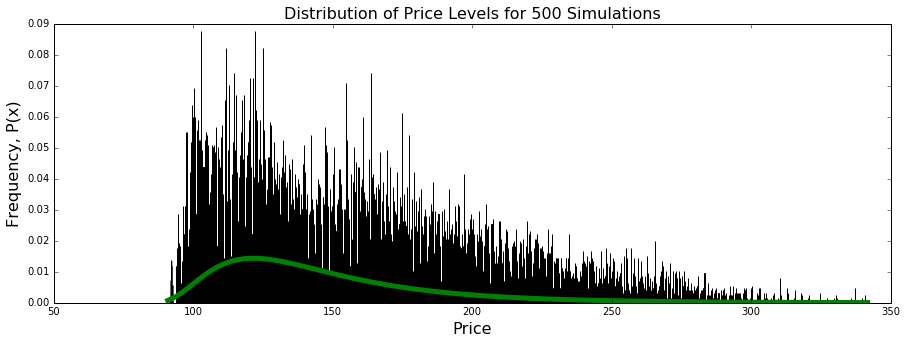

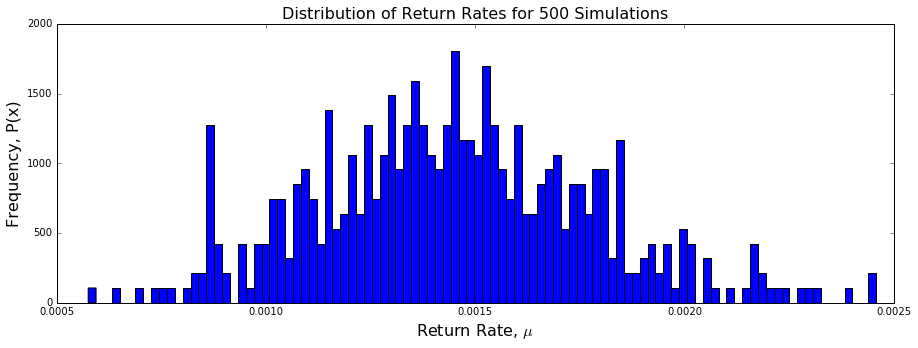

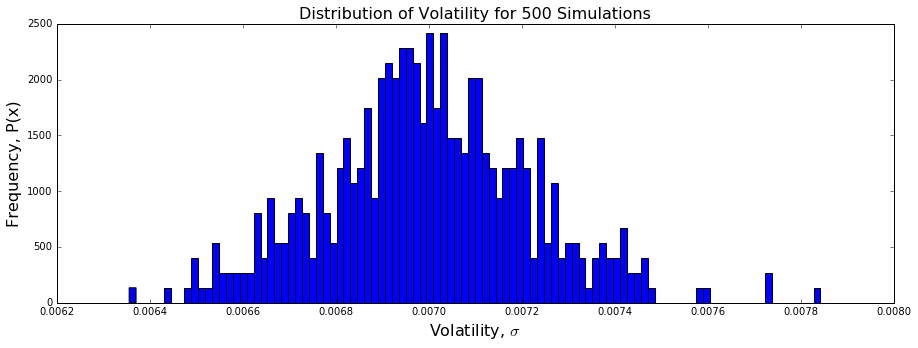

In [11]:
#Plot the distributions of the price levels and returns to check the validity of the code
#Price Levels should be lognormally distributed according to Geometric Brownian Motion Model
#Return Rate and Volatility should be normally distributed

#Plot Price Levels
plt.figure(figsize=(15,5))
plt.title("Distribution of Price Levels for %d Simulations" %sim_count, fontsize=16)
plt.xlabel("Price",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(prices_multiple,bins=100,normed=1,label="R")

#Compare with Lognormal distribution with Mean and Stdev given below
lognorm_mean = Si*np.exp(mu*N*dt)
lognorm_var = (Si**2)*np.exp(2*mu*N*dt)*(np.exp((sigma**2)*N*dt)-1)
s,loc,scale = stats.lognorm.fit(prices_multiple)
lognorm_dist = stats.lognorm.pdf(bins,s,loc,scale)
plt.plot(bins,lognorm_dist,"g",lw=5,label="Lognormal PDF")  #plot the expected lognormal density distribution

#Plot the return and volatility distribution
plt.figure(figsize=(15,5))
plt.title("Distribution of Return Rates for %d Simulations" %sim_count, fontsize=16)
plt.xlabel("Return Rate, $\mu$",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(mu_arr,bins=100,normed=1,label="R")

plt.figure(figsize=(15,5))
plt.title("Distribution of Volatility for %d Simulations" %sim_count, fontsize=16)
plt.xlabel("Volatility, $\sigma$",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(sigma_arr,bins=100,normed=1,label="sigma")

In [18]:
print(lognorm_mean)
print(np.sqrt(lognorm_var))

211.700001661
33.3402911627


### Exploration: Testing the Model with Real Stock Data
Once the model was checked to work correctly, it was then tested with real stock data. Nike (NKE) stock prices from 2013-2015 were used to backtest the model. Values for annualized return rates and volatility rates for NKE stock were obtained from Yahoo Finance and Monte Carlo simulations were run using the Geometric Brownian Motion model described above. 

The following cell shows how the stock prices were obtained using the get_historical function with the yahoo finance module. The annualized return rate, $\mu$ and the standard deviation rate, $\sigma$ were obtained from the historical listing of stock prices, as is actually done in practice. The return rate, $\mu$ serves as a predictor for the upward drift in the Geometric Brownian Motion model, whereas $\sigma$ characterizes the volatility and the inherent risk in the stock price evolution over time.

The following values were used to test the code with real stock data for NKE over a two year period. Assuming approximately 250 working days in a year, N = 500 characterizes a time frame of about two years. The return and volatility rates were calculated by importing the data into a separate .csv file and doing the required calculations for the return and standard deviation of the stock prices.
1. The start price, $S_0$ was taken to be 52.4 as on Jan 02, 2013. The expected price $S_t$ at the end of the two year period is expected to be around 98.6.
2. The two-year annualized rate of return was taken to be $\mu = 0.13$ which was calculated using the list of prices generated from the Yahoo Finance historical records. 
3. The two-year annualized volatility rate was also obtained from the prices, $\sigma = 0.05$.

The following code calls the functions to generate the random walks by the Geometric Brownian Motion model.

In [30]:
#Obtaining stock prices using the yahoo finance module
#The return and volatility rates were calculated using these prices.
k = Share('nke')
pprint(k.get_historical('2013-01-01', '2015-01-01'))

[{'Adj_Close': '47.446902',
  'Close': '96.150002',
  'Date': '2014-12-31',
  'High': '97.610001',
  'Low': '96.040001',
  'Open': '96.970001',
  'Symbol': 'nke',
  'Volume': '4697400'},
 {'Adj_Close': '47.807131',
  'Close': '96.879997',
  'Date': '2014-12-30',
  'High': '97.300003',
  'Low': '96.620003',
  'Open': '96.879997',
  'Symbol': 'nke',
  'Volume': '4146800'},
 {'Adj_Close': '48.01439',
  'Close': '97.300003',
  'Date': '2014-12-29',
  'High': '97.650002',
  'Low': '96.610001',
  'Open': '96.610001',
  'Symbol': 'nke',
  'Volume': '4017800'},
 {'Adj_Close': '47.78246',
  'Close': '96.830002',
  'Date': '2014-12-26',
  'High': '97.209999',
  'Low': '96.25',
  'Open': '96.510002',
  'Symbol': 'nke',
  'Volume': '3144400'},
 {'Adj_Close': '47.515987',
  'Close': '96.290001',
  'Date': '2014-12-24',
  'High': '97.349998',
  'Low': '96.089996',
  'Open': '96.400002',
  'Symbol': 'nke',
  'Volume': '2439600'},
 {'Adj_Close': '47.358078',
  'Close': '95.970001',
  'Date': '2014-12-

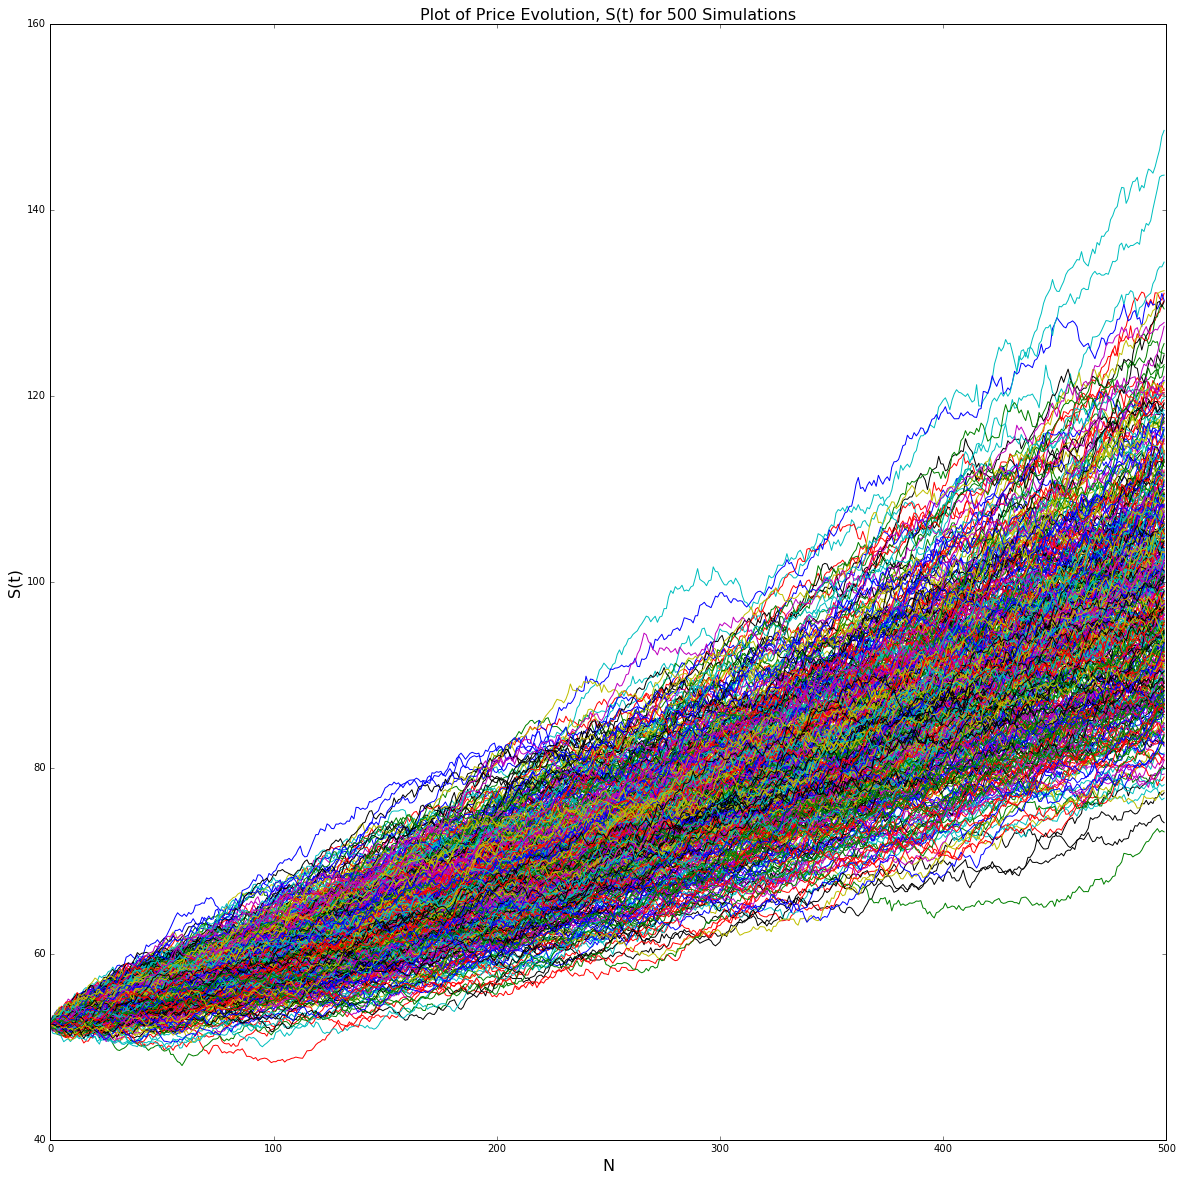

In [26]:
#Run multiple simulations with sample values for the input parameters
mu = 0.13
sigma = 0.05
Si = 52.4
N = 500
dt = 0.01
sim_count = 500

#Call the function and run the simulations
prices_multiple, mu_arr, sigma_arr = gen_multiple(mu, sigma, dt, Si, N, sim_count)

In [29]:
lognorm_mean = Si*np.exp(mu*N*dt)
lognorm_var = (Si**2)*np.exp(2*mu*N*dt)*(np.exp((sigma**2)*N*dt)-1)

print(lognorm_mean)
print(np.sqrt(lognorm_var))

100.37433944
11.2573531581


### Interpreting the Simulated Results
It can be seen from the random walks generated in the figure above, that the model we use here does at a first glance appear to produce a price evolution in the correct direction and of the approximate magnitude. Since it is a random walk model, it is important to note that results must only be interpreted for the price level or return distribution as a whole and not for an individual simulation. The code and figures below generate the required distribution plots for the price levels and return and volatility rates.

First it is important to note that the calculated mean using the equation, $E[S_t] = S_0 e^{(\mu N t)}$ for the log-normally distributed price levels was 100.374. This lies within a 5% error margin of the true value of 98.6 and was generated using 500 simulations.

Secondly, it can be seen that all the properties of Geometric Brownian Motion are satisfied - the price levels follow a log-normal distribution and the return and volatility rates are normally distributed with the means corresponding to the input parameter values.

Note that simulations were also run for other time frames and with different stock prices, and on average the model was shown to give values within 10% of the true value of $S_t$.

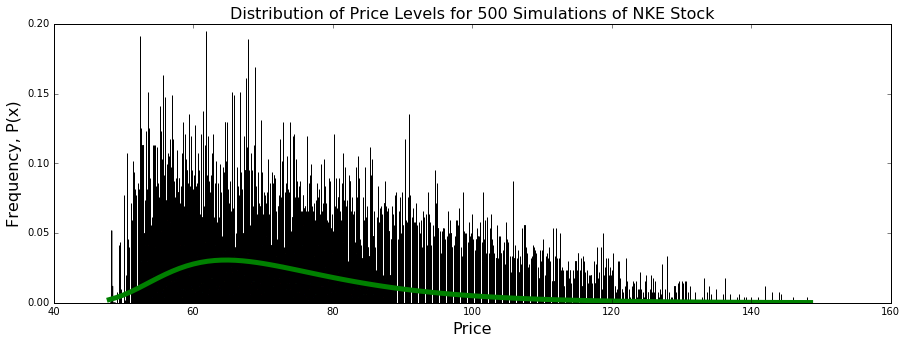

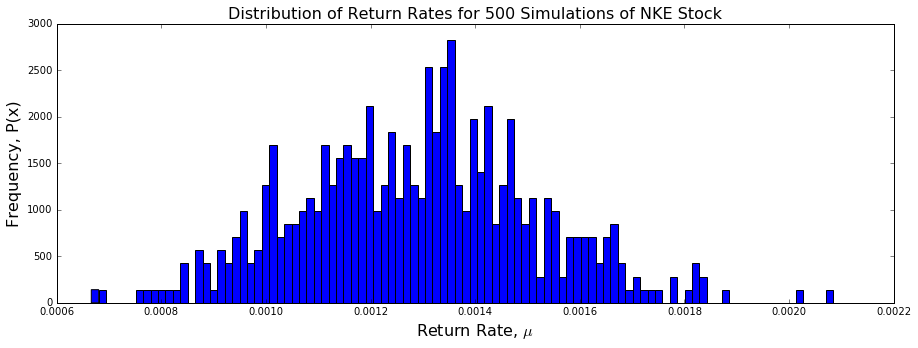

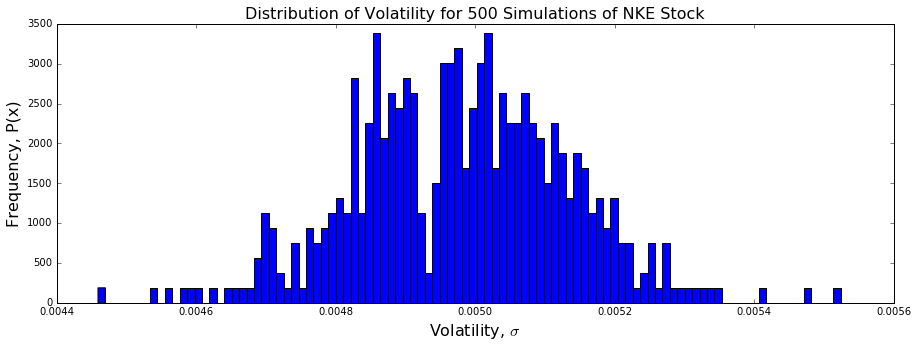

In [31]:
#Plot the distributions of the price levels and returns to check the code for real data
#Price Levels should be lognormally distributed according to Geometric Brownian Motion Model
#Return Rate and Volatility should be normally distributed

#Plot Price Levels
plt.figure(figsize=(15,5))
plt.title("Distribution of Price Levels for %d Simulations of NKE Stock" %sim_count, fontsize=16)
plt.xlabel("Price",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(prices_multiple,bins=100,normed=1,label="R")

#Compare with Lognormal distribution with Mean and Stdev given below
lognorm_mean = Si*np.exp(mu*N*dt)
lognorm_var = (Si**2)*np.exp(2*mu*N*dt)*(np.exp((sigma**2)*N*dt)-1)
s,loc,scale = stats.lognorm.fit(prices_multiple)
lognorm_dist = stats.lognorm.pdf(bins,s,loc,scale)
plt.plot(bins,lognorm_dist,"g",lw=5,label="Lognormal PDF")  #plot the expected lognormal density distribution

#Plot the return and volatility distribution
plt.figure(figsize=(15,5))
plt.title("Distribution of Return Rates for %d Simulations of NKE Stock" %sim_count, fontsize=16)
plt.xlabel("Return Rate, $\mu$",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(mu_arr,bins=100,normed=1,label="R")

plt.figure(figsize=(15,5))
plt.title("Distribution of Volatility for %d Simulations of NKE Stock" %sim_count, fontsize=16)
plt.xlabel("Volatility, $\sigma$",fontsize=16)
plt.ylabel("Frequency, P(x)",fontsize=16)
n, bins, patches=plt.hist(sigma_arr,bins=100,normed=1,label="sigma")

### Comments and Conclusions
From the simulation results generated, it can be seen that the Geometric Brownian motion model functions well to model stock prices using the stochastic process discussed above. The model was first checked to satify properties of Geometric Brownian Motion and then subsequently backtested with real stock price data. NKE stock prices from 2013-2015 were used to calculate values of $\mu$ and $\sigma$ which were then used to run simulations for that period. The simulated results and true value of the stock prices were shown to be similar within a 5% error margin.

The model was also tested for other time frames and with other stock prices (results not shown here since the simulation results took up lot of space and time to run) and was on average within 10% of the true expected value of $S_t$. This was an impressive result considering that the model incorporates several assumptions to help simplify calculations.

This code could be further improved to incorporate/calculate different return and volatility rates based on the time frame under consideration, and also customize simulations based on the timestep (or sampling frequency) of the stock data for the evolution using the stochastic process described above.